,Layer No.,Resistivity(Ωm),Thickness(m),Depth (m),Elev.,Interpreted Lithology
0,1,22.541,1.4790,1.4790,306.52,Overburden/top soil with kankars
1,2,921.98,0.55382,2.0328,305.97,Overburden/top soil with kankars
2,3,22.211,4.0141,6.0469,301.95,Overburden/top soil with kankars
3,4,8693.6,--,--,--,Hard granite


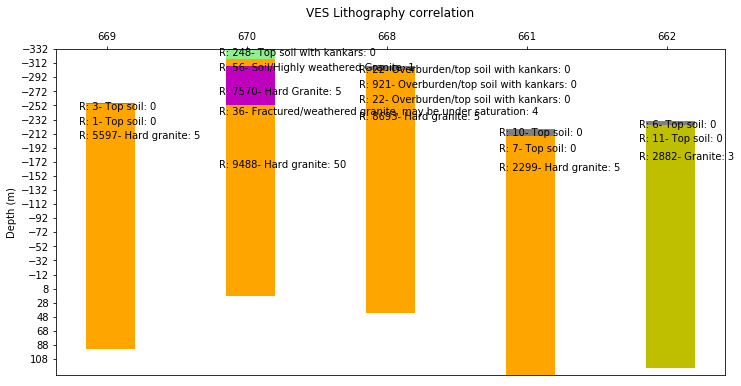

In [81]:
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from pickle_fns import *
import math
from scipy.interpolate import griddata,interp2d

def str_array2floats(strarray):
    floats=[]
    for s in strarray:
        try:
            floats.append(float(s))
        except:
            floats.append(np.nan)
    return floats
def get_lables(df,lith_dict):
    labels=[]
    for s in df['Interpreted Lithology'].values:
        for i in range(len(lith_dict)):
            if s in lith_dict[i]:
                if i in labels and i!=labels[-1]:
                    labels.append(i*10)
                else:
                    labels.append(i)
                break
    return labels
def make_same_numb_layers(master_l_thicknesses,lith_labels):
    layersinlocations=[len(l) for l in master_l_thicknesses]
    maxls=max(layersinlocations)
    j=-1
    for ml,ll in zip(master_l_thicknesses,lith_labels):
        j +=1
        if len(ml)<maxls:
            for i in range(maxls-len(ml)):
                ml.append(0)
                ll.append(-1)
                # ll.append(-1)
    loc_layers=np.array(master_l_thicknesses)
    return loc_layers,np.array(lith_labels)
# np.set_printoptions(precision=3,
def get_lithdict():
        #preparation of lith dictionary
    fg_undersat=['Fractured Granite, may be under saturation',
            'Fractured granite , may be under saturation',
            'Fractured granite, may be under saturation',
            'Fractured/weathered granite, may be under saturation']
    gran= ['Granite',]
    hard_gran=['Hard Granite', 'Hard granite', ]
    high_weath_gr =['Highly Weathered granite','Highly weathered Granite', 'Highly weathered granite','Soil with kankars/Highly weathered Granite',
            'Soil/Highly weathered Granite',]
    soil_w_kankar= ['Overburden/top soil with kankars', 'Soil', 'Soil with kankars', 'Top Soil with kankars',
            'Top soil', 'Top soil with kankars', 'Top soils with kankars',]
    weather_gran=[ 'Weathered Granite', 'Weathered granite']
    return {0:soil_w_kankar,1:high_weath_gr,2:weather_gran,3:gran ,4:fg_undersat,5:hard_gran,}

# vesdf,data_dfs=load_pkl('tikamgarh.pkl')
# vesnos=vesdf['VES No.'].values
# locations4panel=vesnos[0:nlocs]


# plot_VES_panel(vesdf,data_dfs,locations4panel)
def plot_VES_panel(vesdf,data_dfs,locations4panel):
    vesnos=list(vesdf['VES No.'].values)
    master_l_thicknesses=[]
    lith_labels=[]
    liths=[]
    max_strata_thickness=350
    lith=[]
    res=[]
    # E,N=vesdf.Easting.values.astype(np.float),vesdf.Northing.values.astype(np.float)

    elevations=str_array2floats(vesdf.RL.values)
    lith_dict=get_lithdict()
    ves_data_dfs=[]
    eles=[]
    for loc in locations4panel:
        indx=vesnos.index(loc)
        ves_data_dfs.append(data_dfs[indx])
        eles.append(elevations[indx])

    #utilization of get labels
    # for df in data_dfs:
    #     df['lith_label']=get_lables(df,lith_dict) 
        # lith.extend(df['Interpreted Lithology'].values)   
    # lith_labels=df['lith_label'].values
    master_l_thicknesses=[]
    lith_labels=[]
    for df in ves_data_dfs:
    #     print(df['Thickness(m)'].values.astype(np.float))
        layers_values=str_array2floats(df['Thickness(m)'].values)
        lastlayer_thickness=[max_strata_thickness-np.nansum(layers_values) if math.isnan(x) else x for x in layers_values]
#         print(lastlayer_thickness)
        master_l_thicknesses.append(list(lastlayer_thickness))
        lith_labels.append(list(get_lables(df,lith_dict) ))
        # lith_labels=np.append(lith_labels,df['lith_label'].values,axis=1)
        liths.append(df['Interpreted Lithology'].values)
        res.append(df['Resistivity(Ωm)'].values.astype(np.float))   

    master_l_thicknesses,lith_labels=make_same_numb_layers(master_l_thicknesses,lith_labels)
    lithologies=np.array(liths)
    resistivities=np.array(res)
    lith_lbls=np.array(lith_labels)

#     print(master_l_thicknesses)
    ths=np.array(master_l_thicknesses)
#     print(ths.shape)
    nlocs=ths.shape[0]
    nlayers=ths.shape[1]+1


    vess=np.append(-np.array(eles),ths.T).reshape(nlayers,nlocs)
    

    colors=['grey','lightgreen','lightblue','y','m','orange']
    fcolors=colors[0:nlayers+1]  

    vesBarData = vess.copy()
    onevess=vesBarData.T[0]

    _,N = vesBarData.shape
    inds = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence


    p1=[]
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    bottom=vesBarData[0]
    for i in range(nlocs):
        onevess=vesBarData.T[i]
        onelbs=lith_lbls[i]
        ind=inds[i]
#         print(onelbs)
        p1.append(ax.bar(ind+0.2,onevess[0], width,color=fcolors[onelbs[0] if onelbs[0]<10 else int(onelbs[0]/10)] ,ecolor='black'))
        bottom = onevess[0]
#         break
        
        for j in range(1,nlayers): 
            idx=onelbs[j-1] if onelbs[j-1]<10 else int(onelbs[j-1]/10)
            mycolor=fcolors[idx]
#             print(onevess[j],bottom,mycolor,onelbs[j-1],idx)
            p1.append(ax.bar(ind+0.2,onevess[j], width,bottom=bottom,color=mycolor))
            bottom += onevess[j]
    #     print(fcolor[5])

    patterns = ['-', '+', 'x', '\\', '*', 'o', 'O', '.',
                '-', '+', 'x', '\\', '*', 'o', 'O']
    nlayers,nlocs=vess.shape

    patterns = np.array(patterns[0:nlayers]*nlocs)
    patterns=patterns.reshape(nlocs,nlayers)

    # for bar, pattern in zip(p1, patterns.T.ravel()):
    #     bar.set_hatch(pattern)
    ax.set_ylabel('Depth (m)')
    # ax.set_title('Scores by group and gender')
    ax.set_xticks(inds+0.0+width/2, minor=False)
    ax.set_xticklabels( locations4panel, minor=False)
    ax.xaxis.tick_top()

    x_coords=inds-0.2+width/2

    for ls,rs,llb,vs,xc in zip(lithologies,resistivities,lith_lbls,vess.T,x_coords):
        cvs=np.cumsum(vs)
        # print(vs,rs)
        adder=10
        for i in range(len(ls)):        
            ax.annotate('R: '+str(int(rs[i]))+'- '+ls[i]+': '+str(llb[i]), xy=(xc, cvs[i]+ adder))
            adder+=20
            # print(xc, cvs[i])
    ax.set_yticks(np.arange(min(vess[0,:]), bottom, 20))
    # ax.legend(p1, layers,loc=4)
    ax.invert_yaxis()
    # ax.titlepad=300
    plt.title('VES Lithography correlation',y=1.08)
    plt.show()
vesdf,data_dfs=load_pkl('tikamgarh.pkl')
vesnos=vesdf['VES No.'].values
nlocs=4
locations4panel=['669','670', '668', '661', '662']
plot_VES_panel(vesdf,data_dfs,locations4panel)

In [88]:
# lithologies,resistivities,lith_lbls
# master_l_thicknesses,lith_labels
vesnos=list(vesdf['VES No.'].values)
for loc in locations4panel:
    indx=vesnos.index(loc)
    print(loc,': ',indx)
    ves_data_dfs.append([indx])
# ves_data_dfs
data_dfs[13]

669 :  12
670 :  13
668 :  11
661 :  4
662 :  5


,Layer No.,Resistivity(Ωm),Thickness(m),Depth (m),Elev.,Interpreted Lithology
0,1,248.95,0.67665,0.67665,113.32,Top soil with kankars
1,2,56.155,13.799,14.476,99.524,Soil/Highly weathered Granite
2,3,7570.5,8.7875,23.263,90.737,Hard Granite
3,4,36.825,55.410,78.673,35.327,"Fractured/weathered granite, may be under satu..."
4,5,9488.9,--,--,--,Hard granite


In [99]:
# eles,ths.T,np.append(-np.array(eles),ths.T)
string='Fractured/weathered granite, may be under saturation'
st=string.split()
len(string)
limitLtrsperline=20

def sliceLongString0(string,limitLtrsperline):
    if len(string)>limitLtrsperline:    
        lines2bmade=round(len(string)/limitLtrsperline)
        wordsperline=round(len(st)/lines2bmade)
        lines=[]
        for i in range(0,len(st),wordsperline):
            lines.append(' '.join(st[i:i+wordsperline]))
        print(lines)



' Fractured/weathered granite,/n may be under saturation'

[0 1 2 5]
5
[ 0  1  3 -1]
-1
[0 0 1 5]
5
[ 0  2  5 -1]
-1


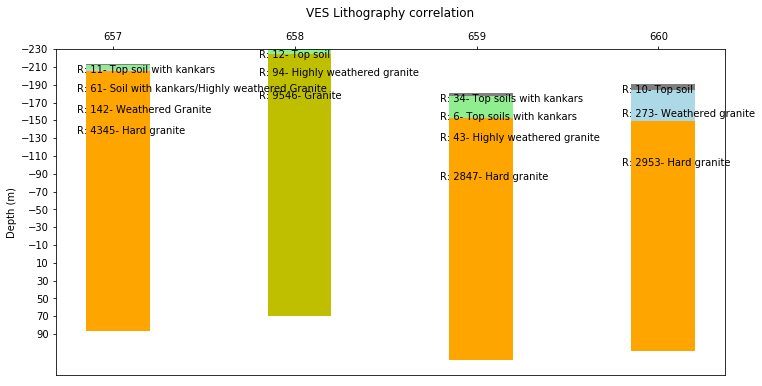

In [51]:
fcolors

['grey', 'lightgreen', 'lightblue', 'y', 'm']